# Train and Predict
Train and evaluate model
- <a href='#1'>1. lightgbm</a> 
- <a href='#2'>2. task2</a> 
- <a href='#3'>3. ensemble</a>

In [1]:
# ! pip install pyarrow -i http://mirrors.aliyun.com/pypi/simple/ --trusted-host mirrors.aliyun.com
%load_ext autoreload
%autoreload 2
import sys
import os
import gc
from time import time
from datetime import timedelta, datetime
import base64

import pandas as pd
from IPython.core.display import display, HTML
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import lightgbm as lgb
from sklearn import metrics

sys.path.append('../')
import conf
from mlpipeline import (
    feature_engineering,
    train,
    predict,
)
from utils import (
    check_columns,
    check_nan_value,
    #     correct_colum_type,
    load_model,
    plot_dist_of_cols,
)

In [2]:
# global settings
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns',1000)
pd.set_option('display.width',100)
sns.set(rc={'figure.figsize':(20,10)})
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [3]:
# global variables
DEFAULT_MISSING_FLOAT = 0
FAULT_TAG = 1

In [4]:
# functions
def __dummy():
    pass

### <a id='1'> 1.lightgbm</a>

In [5]:
! du -sh ../data/*

4.3M	../data/chunk_data_for_test.h5
4.2G	../data/data_2017_all.h5
4.7G	../data/data_2017_new_all.h5
2.3G	../data/data_2017_tag_flag.h5
2.5G	../data/data_2017_tag_flag_raw.h5
20M	../data/data_201808_test.h5
41M	../data/data_201808_test_all.h5
46M	../data/data_201808_test_b.h5
24M	../data/data_201808_test_raw.h5
6.9G	../data/data_2018_all.h5
7.9G	../data/data_2018_new_all.h5
3.9G	../data/data_2018_tag_flag.h5
4.2G	../data/data_2018_tag_flag_raw.h5
36K	../data/disk_sample_fault_tag.csv
1.2G	../data/disk_sample_smart_log_201707.csv
228M	../data/disk_sample_smart_log_201707_norm.csv
233M	../data/disk_sample_smart_log_201707_raw.csv
2.2G	../data/disk_sample_smart_log_201708.csv
446M	../data/disk_sample_smart_log_201708_norm.csv
460M	../data/disk_sample_smart_log_201708_raw.csv
2.2G	../data/disk_sample_smart_log_201709.csv
450M	../data/disk_sample_smart_log_201709_norm.csv
468M	../data/disk_sample_smart_log_201709_raw.csv
2.5G	../data/disk_sample_smart_log_201710.csv
507M	../data/disk_sample_

In [6]:
# feature engineering
params = {
    'train_filename':'data_2018_new_all.h5',  # train file we want to load
    'test_filename': 'data_201808_test_b.h5',
    'train_fe_save_filename':'train_fe_df_02_01_b_all.feather',  # naming the train fe by the start date of train
    'test_fe_save_filename': 'test_fe_df_02_01_b_all.feather',  # same as train fe
    'use_sampling': False,
    'sample_validset': False,  # whether do sampling for valid set and train set at the same time
    'train_start_date': '2018-02-01',
    'train_end_date': '2018-06-30',  # include validation data duration
    'valid_start_date': '2018-06-01',  # for judge the val set from train set in sampling process
    'valid_end_date': '2018-06-30',
    'use_model_one': False,  # only use model one for train or not 
    'num_processes': 17,
}

train_fe_df, test_fe_df = feature_engineering(**params)

2020-03-16 02:25:18,555 - mlpipeline.feature_engineering - INFO - feature_engineering开始
2020-03-16 02:25:18,557 - mlpipeline.feature_engineering - INFO - _load_dataset_by_filename开始
2020-03-16 02:25:18,558 - mlpipeline.feature_engineering - INFO - 加载训练数据集: ../data/data_2018_new_all.h5
2020-03-16 02:27:53,202 - mlpipeline.feature_engineering - INFO - 加载训练数据集完成,共用时: 0:02:35
2020-03-16 02:27:53,206 - mlpipeline.feature_engineering - INFO - 加载测试数据集: ../data/data_201808_test_b.h5
2020-03-16 02:27:55,812 - mlpipeline.feature_engineering - INFO - 加载测试数据集完成,共用时: 0:00:03
2020-03-16 02:27:55,814 - mlpipeline.feature_engineering - INFO - _load_dataset_by_filename已完成，共用时0:02:37
2020-03-16 02:27:55,815 - mlpipeline.feature_engineering - INFO - _data_preprocess开始
2020-03-16 02:28:16,470 - mlpipeline.feature_engineering - INFO - train使用的cols: ['smart_1_normalized', 'smart_7_normalized', 'smart_197_normalized', 'smart_198_normalized', 'smart_1raw', 'smart_4raw', 'smart_5raw', 'smart_7raw', 'smart_9raw

2020-03-16 02:29:02,981 - utils.utils - INFO - test: smart_188raw - 179 
2020-03-16 02:29:03,279 - utils.utils - INFO - train: smart_189raw - 1409 
2020-03-16 02:29:03,280 - utils.utils - INFO - test: smart_189raw - 2 
2020-03-16 02:29:03,491 - utils.utils - INFO - train: smart_190raw - 78 
2020-03-16 02:29:03,493 - utils.utils - INFO - test: smart_190raw - 37 
2020-03-16 02:29:03,764 - utils.utils - INFO - train: smart_192raw - 1355 
2020-03-16 02:29:03,766 - utils.utils - INFO - test: smart_192raw - 339 
2020-03-16 02:29:04,083 - utils.utils - INFO - train: smart_193raw - 38176 
2020-03-16 02:29:04,084 - utils.utils - INFO - test: smart_193raw - 10013 
2020-03-16 02:29:04,300 - utils.utils - INFO - train: smart_194raw - 78 
2020-03-16 02:29:04,301 - utils.utils - INFO - test: smart_194raw - 37 
2020-03-16 02:29:11,388 - utils.utils - INFO - train: smart_195raw - 13646875 
2020-03-16 02:29:11,390 - utils.utils - INFO - test: smart_195raw - 153733 
2020-03-16 02:29:11,584 - utils.utils

2020-03-16 03:08:26,862 - utils.utils - INFO - smart_240raw_max_30 - 62.68%
2020-03-16 03:08:26,910 - utils.utils - INFO - smart_241raw_max_30 - 62.68%
2020-03-16 03:08:26,958 - utils.utils - INFO - smart_242raw_max_30 - 62.68%
2020-03-16 03:08:27,001 - utils.utils - INFO - smart_1_normalized_diff_for_last_period_30 - 0.46%
2020-03-16 03:08:27,044 - utils.utils - INFO - smart_7_normalized_diff_for_last_period_30 - 0.46%
2020-03-16 03:08:27,087 - utils.utils - INFO - smart_197_normalized_diff_for_last_period_30 - 0.46%
2020-03-16 03:08:27,130 - utils.utils - INFO - smart_198_normalized_diff_for_last_period_30 - 0.46%
2020-03-16 03:08:27,175 - utils.utils - INFO - smart_1raw_diff_for_last_period_30 - 0.46%
2020-03-16 03:08:27,218 - utils.utils - INFO - smart_4raw_diff_for_last_period_30 - 0.46%
2020-03-16 03:08:27,260 - utils.utils - INFO - smart_5raw_diff_for_last_period_30 - 0.46%
2020-03-16 03:08:27,302 - utils.utils - INFO - smart_7raw_diff_for_last_period_30 - 0.46%
2020-03-16 03:08

2020-03-16 03:43:37,001 - mlpipeline.train - INFO - train开始
2020-03-16 03:43:37,003 - mlpipeline.train - INFO - 当前模式:eval on model 1, train on model 1, 当前使用模型:lgb, 使用cv:False, 训练集日期:2018-03-01 - 2018-04-30, 验证集日期:2018-06-01 - 2018-06-30
2020-03-16 03:43:44,928 - mlpipeline.train - INFO - train_pipeline_lgb开始
2020-03-16 03:43:44,931 - mlpipeline.train - INFO - 连续性特征数量: 80
2020-03-16 03:43:44,932 - mlpipeline.train - INFO - 离散性特征数量: 0
2020-03-16 03:43:58,257 - mlpipeline.train - INFO - 训练集正负样本比:3576:5793813(i.e. 0.00062)
2020-03-16 03:43:59,108 - mlpipeline.train - INFO - 验证集正负样本比:2099:2846236(i.e. 0.00074)
2020-03-16 03:43:59,110 - mlpipeline.train - INFO - eval参数:{'objective': 'binary', 'boosting': 'dart', 'learning_rate': 0.001, 'scale_pos_weight': 15, 'num_leaves': 16, 'metric': ['auc'], 'subsample': 0.8, 'colsample_bytree': 0.6, 'num_threads': 10, 'lambda_l2': 0.8, 'lambda_l1': 0.8, 'random_state': 2019, 'min_data_in_leaf': 80, 'num_boost_round': 50, 'device': 'cpu'}
/opt/conda/lib/

[1]	training's auc: 0.726073	valid_1's auc: 0.628523


/opt/conda/lib/python3.6/site-packages/lightgbm/callback.py:188: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[2]	training's auc: 0.741049	valid_1's auc: 0.620662
[3]	training's auc: 0.752637	valid_1's auc: 0.738842
[4]	training's auc: 0.766854	valid_1's auc: 0.752961
[5]	training's auc: 0.773338	valid_1's auc: 0.755866
[6]	training's auc: 0.773905	valid_1's auc: 0.755947
[7]	training's auc: 0.771781	valid_1's auc: 0.755946
[8]	training's auc: 0.771713	valid_1's auc: 0.755939
[9]	training's auc: 0.776382	valid_1's auc: 0.756759
[10]	training's auc: 0.776689	valid_1's auc: 0.761042
[11]	training's auc: 0.776705	valid_1's auc: 0.761145
[12]	training's auc: 0.776695	valid_1's auc: 0.761171
[13]	training's auc: 0.776649	valid_1's auc: 0.761205
[14]	training's auc: 0.776644	valid_1's auc: 0.761174
[15]	training's auc: 0.776647	valid_1's auc: 0.761174
[16]	training's auc: 0.77661	valid_1's auc: 0.761152
[17]	training's auc: 0.776615	valid_1's auc: 0.761147
[18]	training's auc: 0.776619	valid_1's auc: 0.761142
[19]	training's auc: 0.777114	valid_1's auc: 0.763518
[20]	training's auc: 0.777099	valid_1

2020-03-16 03:44:53,577 - mlpipeline.train - INFO - eval最优轮数: 0, eval最优auc: 0.7662459265736133
2020-03-16 03:44:53,579 - mlpipeline.train - INFO - 模型训练用时:0:00:54
2020-03-16 03:44:53,588 - mlpipeline.train - INFO - 特征重要性：           Value                                       Feature
46  1.182228e+07            smart_5raw_diff_for_last_period_30
67  9.893743e+06                                    smart_5raw
26  8.626011e+06                             smart_5raw_max_30
54  3.928881e+06          smart_193raw_diff_for_last_period_30
79  3.427047e+06                                  smart_199raw
6   3.139778e+06                             smart_5raw_min_30
19  2.801425e+06                           smart_199raw_min_30
28  2.179327e+06                             smart_9raw_max_30
34  2.111869e+06                           smart_193raw_max_30
11  1.704388e+06                           smart_188raw_min_30
47  1.597426e+06            smart_7raw_diff_for_last_period_30
39  1.291213e+06        

[50]	training's auc: 0.781318	valid_1's auc: 0.766246


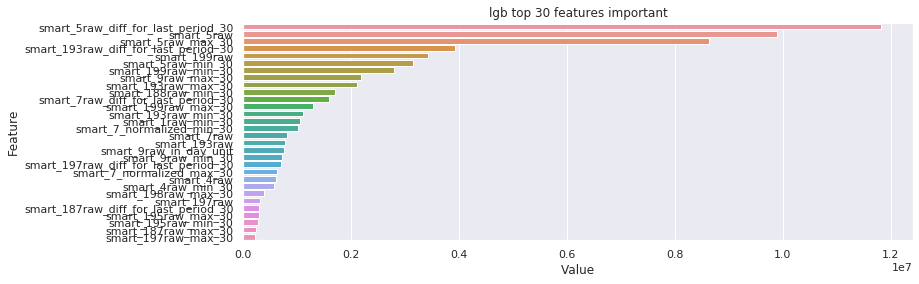

2020-03-16 03:45:10,980 - mlpipeline.train - INFO - 分类阈值: 0.994
2020-03-16 03:45:10,982 - mlpipeline.train - INFO - Val Acc: 99.39%
2020-03-16 03:45:10,983 - mlpipeline.train - INFO - Precision, Recall and F1-Score...
2020-03-16 03:45:10,984 - mlpipeline.train - INFO -               precision    recall  f1-score   support

         无故障     0.9996    0.9943    0.9969   2846236
         有故障     0.0499    0.4059    0.0888      2099

    accuracy                         0.9939   2848335
   macro avg     0.5247    0.7001    0.5429   2848335
weighted avg     0.9989    0.9939    0.9963   2848335

2020-03-16 03:45:10,985 - mlpipeline.train - INFO - Confusion Matrix...
2020-03-16 03:45:10,986 - mlpipeline.train - INFO - [[2830000   16236]
 [   1247     852]]
2020-03-16 03:45:11,019 - mlpipeline.train - INFO - 竞赛recall: 0.5079365079365079
2020-03-16 03:45:11,020 - mlpipeline.train - INFO - 竞赛precision: 0.08
2020-03-16 03:45:11,022 - mlpipeline.train - INFO - 竞赛f1-score: 0.13822894168466524
2020-

In [21]:
# eval
model_params = {
    "objective": "binary",
    "boosting": 'dart',  # gbdt, dart
    "learning_rate": 0.001,
#     'learning_rates':
    "scale_pos_weight":15,
#     "is_unbalance": True,
    "num_leaves": 16,
#     "max_bin":255,
#     'min_gain_to_split': 20,
#     "max_depth":6,
    "metric": ["auc"],
    "subsample": 0.8,
    "colsample_bytree": 0.6,
    "num_threads": 10,
    "lambda_l2": 0.8, 
    "lambda_l1": 0.8,
    "random_state": 2019,
    "min_data_in_leaf": 80,
    "num_boost_round": 50,
    "device": 'cpu',
#     'boost_from_average':False
}  

drop_cols = [   
                 'smart_240raw',
                 'smart_240raw_min_30',
                'smart_240raw_max_30',
                 'smart_240raw_diff_for_last_period_30',
                'smart_241raw',
                 'smart_241raw_min_30',
                'smart_241raw_max_30',
                 'smart_241raw_diff_for_last_period_30',
                 'smart_242raw',
                 'smart_242raw_min_30',
                 'smart_242raw_max_30',
                 'smart_242raw_diff_for_last_period_30',
                ]

# drop_cols = ['serial_number_feat']
# drop_cols =[]
params = {
    'model_params': model_params,
    'model_name': 'lgb',
    'train_fe_filename': 'train_fe_df_02_01_b_all.feather',
    'is_eval': True,
    "use_standard": False,  # whether using sklearn-standard
    'use_log': False,
    'use_cv': False,
    'drop_cols':drop_cols,
    'train_start_date': '2018-03-01',  # when using cv, should be same as the the earliest day of cv train
    'train_end_date': '2018-04-30', # when using cv, should be same as the the latest day of cv valid
    'eval_on_model_id': 1,
    'train_on_model_id':1, # 1 ,2 , None
    'save_feat_important': False,
    'valid_start_date':'2018-06-01', 
    'valid_end_date': '2018-06-30',
    'train_date_list':  [['2018-03-01','2018-04-30']],
    'val_date_list': [['2018-06-01','2018-06-30']],
    'n_fold': 1
}

model, eval_df = train(**params)

In [6]:
# train
model_params = {
    "objective": "binary",
    "boosting": 'dart',
    "learning_rate": 0.001,
#     'learning_rates':
    "scale_pos_weight":25,
#     "is_unbalance": True,
    "num_leaves": 64,
#     "max_bin":255,
#     'min_gain_to_split': 20,
#     "max_depth":6,
    "metric": ["auc"],
    "subsample": 0.8,
    "colsample_bytree": 0.6,
    "num_threads": 10,
#     "lambda_l2": 0.4, 
#     "lambda_l1": 0.4,
    "random_state": 2019,
    "min_data_in_leaf": 100,
    "num_boost_round": 50,
    "device": 'cpu',
#     'boost_from_average':False
}  

params = {
    'model_params': model_params,
    'model_name': 'lgb',
    'train_fe_filename': 'train_fe_df_02_01_all.feather',
     'focal_loss_alpha':0.9,
    'focal_loss_gamma':6,
    'drop_cols': drop_cols,
    'is_eval': False,
    'use_standard': False,
    'use_log': False,
    'save_feat_important': False,
    'train_start_date': '2018-05-01',
    'train_end_date': '2018-06-30',
}

model, scaler = train(**params)

NameError: name 'drop_cols' is not defined

In [15]:
# predict 
params = {'model_name': 'lgb',
          'test_fe_filename': 'test_fe_df_02_01_all.feather', 
          'use_standard': False,
          'use_log': False,
          'pred_on_model_id':1,
          'scaler':'',
          'test_month':8,
            }

ret, submission_df = predict(**params)

2020-03-15 23:14:41,480 - mlpipeline.predict - INFO - predict开始
2020-03-15 23:14:41,481 - mlpipeline.predict - INFO - 开始预测, 当前使用模型:lgb, 预测月份:8
2020-03-15 23:14:41,731 - mlpipeline.predict - INFO - 预测样本数:178028
2020-03-15 23:14:41,733 - mlpipeline.predict - INFO - inference_pipeline_ensemble_tree开始
2020-03-15 23:14:42,256 - mlpipeline.predict - INFO - 分类阈值: 0.994
2020-03-15 23:14:42,258 - mlpipeline.predict - INFO - 提交样本个数：90
2020-03-15 23:14:42,259 - mlpipeline.predict - INFO - submission_2020-03-15T23:14:42.249510.csv已保存至../submission/submission_2020-03-15T23:14:42.249510.csv
2020-03-15 23:14:42,260 - mlpipeline.predict - INFO - inference_pipeline_ensemble_tree已完成，共用时0:00:01
2020-03-15 23:14:42,261 - mlpipeline.predict - INFO - lgb预测完成！
2020-03-15 23:14:42,273 - mlpipeline.predict - INFO - predict已完成，共用时0:00:01


In [13]:
submission_df.head()

,dt,serial_number,model,prob,rank,label,manufacturer
150873,2018-08-08,disk_68442,1,0.519233,178028.0,1,A
69775,2018-08-23,disk_17075,1,0.516920,178016.0,1,A
57951,2018-08-10,disk_140248,1,0.515948,178000.0,1,A
55255,2018-08-07,disk_138448,1,0.515931,177990.5,1,A
65539,2018-08-12,disk_14766,1,0.515273,177976.0,1,A


In [ ]:
# check the distribution of test set
# test_fe_df = pd.read_hdf(os.path.join(conf.DATA_DIR, 'test_fe_df.h5'))
# train_fe_df = pd.read_hdf(os.path.join(conf.DATA_DIR, 'train_fe_df.h5'))
# _, cate_cols, cont_cols, _ = check_columns(train_fe_df.dtypes.to_dict())
# test_fe_df = test_fe_df[cate_cols + cont_cols]
# valid_fe_df = train_fe_df[train_fe_df.dt>=split_date][cate_cols + cont_cols]
# train_fe_df = train_fe_df[train_fe_df.dt<split_date][cate_cols + cont_cols]

In [ ]:
# %%time
# proto = GenericFeatureStatisticsGenerator().ProtoFromDataFrames([{'name': 'test', 'table': test_fe_df},
#                                                                 {'name':'train','table':train_fe_df},
#                                                                 {'name':'valid','table':valid_fe_df}])
# protostr = base64.b64encode(proto.SerializeToString()).decode("utf-8")

In [ ]:
# HTML_TEMPLATE = """
#         <script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
#         <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html" >
#         <facets-overview id="elem"></facets-overview>
#         <script>
#           document.querySelector("#elem").protoInput = "{protostr}";
#         </script>"""
# html = HTML_TEMPLATE.format(protostr=protostr)
# display(HTML(html))